In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')
np.random.seed(100)
#import os
#file_dir=os.getcwd()#获取当前工作目录路径
save_model='bp.h5'
window=3#时间窗
scale=2000#归一化参数
amount_of_features=1#特征数量
d=0.05#dropout系数
batch_size=16#批训练数量
epoch=50
#总迭代次数
train_file='alic90_131.xls'#file_dir+'\\data\\alic\\alic90_131.xls'#读取训练集地址
test_file='alic132_136.xls'#file_dir+'\\data\\alic\\alic132_136.xls'#读取测试集地址
save_file='alic_predict_bp.csv'#file_dir+'\\data\\alic\\alic_predict_lstm.csv'#储存预测值地址

In [118]:
#读取数据，构造训练集和测试集的函数
def read_train(file_name,window,scale):
    #读取数据 
    data=pd.read_excel(file_name,header=None) 
    data=data[1]
    #构造针对机器学习模型的数据集
    window=window#时间窗
    data=data.values 
    dataset=data
    for i in range(window):
        zero=np.zeros(i+1)
        temp=np.append(data[i+1:],zero)
        dataset=np.row_stack((dataset,temp))
    dataset=pd.DataFrame(dataset).T
    dataset=dataset.iloc[:-window]
    dataset=dataset/scale#进行伪归一化
    #划分特征与标签
    x=dataset.iloc[:,:-1]
    y=dataset.iloc[:,-1]
    return x,y
def read_test(file_name,window,scale):
    #读取数据 
    data=pd.read_excel(file_name,header=None) 
    data=data.iloc[:,:]
    data=data[0]
    #构造针对机器学习模型的数据集
    window=window#时间窗
    data=data.values 
    dataset=data
    for i in range(window):
        zero=np.zeros(i+1)
        temp=np.append(data[i+1:],zero)
        dataset=np.row_stack((dataset,temp))
    dataset=pd.DataFrame(dataset).T
    dataset=dataset.iloc[:-window]
    dataset=dataset/scale#进行伪归一化
    #划分特征与标签
    x=dataset.iloc[:,:-1]
    y=dataset.iloc[:,-1]
    return x,y

In [119]:
#构造训练集测试集
X_train,y_train=read_train(train_file,window,scale)
X_test, y_test=read_test(test_file,window,scale)
X_train,X_test,y_train,y_test=X_train.values,X_test.values,y_train.values,y_test.values
print(X_train.shape)#通过输出训练集测试集的大小来判断数据格式正确。
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1005, 3)
(117, 3)
(1005,)
(117,)


In [120]:
#建立bp模型 训练 
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
model = Sequential()  #层次模型
model.add(Dense(8,input_dim=window)) #输入层，Dense表示BP层
model.add(Activation('relu'))  #添加激活函数
model.add(Dense(4)) #中间层
model.add(Activation('relu'))  #添加激活函数
model.add(Dense(1))  #输出层
model.compile(loss='mean_squared_error', optimizer='Adam') #编译模型
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 8)                 32        
_________________________________________________________________
activation_29 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_30 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [113]:
#神经网络训练及结果
'''
如果直接加载模型，则不需要运行这一段训练
'''
model.fit(X_train, y_train, epochs =epoch, batch_size = batch_size,verbose=1,validation_split=0.1) #训练模型nb_epoch次
model.save(save_model)#保存模型

Train on 904 samples, validate on 101 samples
Epoch 1/50
904/904 [==============================] - 1s 1ms/step - loss: 2.2861 - val_loss: 1.5672
Epoch 2/50
904/904 [==============================] - 0s 123us/step - loss: 0.9824 - val_loss: 0.5451
Epoch 3/50
904/904 [==============================] - 0s 129us/step - loss: 0.2794 - val_loss: 0.1024
Epoch 4/50
904/904 [==============================] - 0s 123us/step - loss: 0.0346 - val_loss: 0.0054
Epoch 5/50
904/904 [==============================] - 0s 124us/step - loss: 0.0010 - val_loss: 4.2219e-04
Epoch 6/50
904/904 [==============================] - 0s 126us/step - loss: 6.5629e-05 - val_loss: 3.4488e-04
Epoch 7/50
904/904 [==============================] - 0s 118us/step - loss: 6.3371e-05 - val_loss: 3.4494e-04
Epoch 8/50
904/904 [==============================] - 0s 136us/step - loss: 6.3367e-05 - val_loss: 3.4551e-04
Epoch 9/50
904/904 [==============================] - 0s 133us/step - loss: 6.3363e-05 - val_loss: 3.4635e-04
Ep

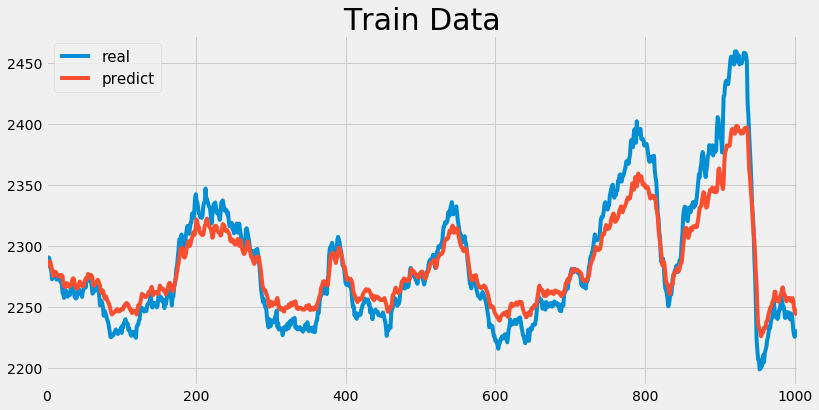

训练集上的MAE/RMSE/MAPE/涨跌准确率
14.62384736473882
18.91254666788781
0.6356943127791739
0.5577689243027888


In [121]:
#加载模型
from keras.models import load_model
model=load_model(save_model)  
#模型进行检验
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)[:,0]*scale#反归一化
y_train=y_train*scale
#展示在训练集上的表现 
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
plt.show()
#输出结果
print('训练集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(np.sqrt(mean_squared_error(y_train_predict, y_train)))
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))

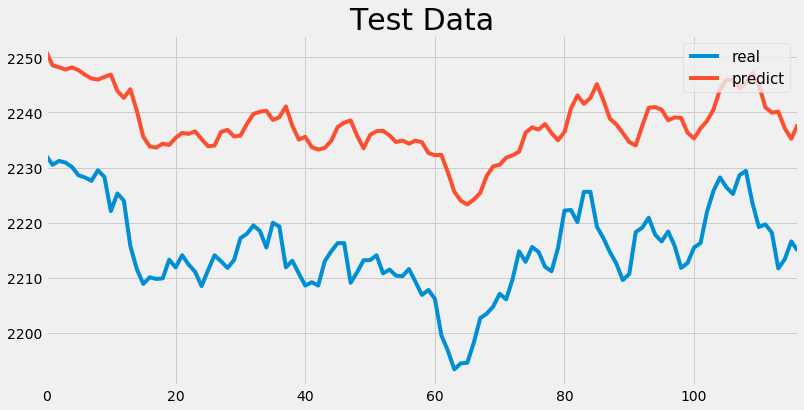

测试集上的MAE/RMSE/MAPE/涨跌准确率
22.58125166933761
22.91301712513301
1.0092964500564967
0.4827586206896552


In [122]:
#在测试集上的预测
y_test_predict=model.predict(X_test)[:,0]*scale
y_test=y_test*scale
#展示在测试集上的表现 
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
plt.show()
print('测试集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(np.sqrt(mean_squared_error(y_test_predict, y_test)))
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))
#储存文件
(pd.DataFrame(y_test_predict)).to_csv(save_file)

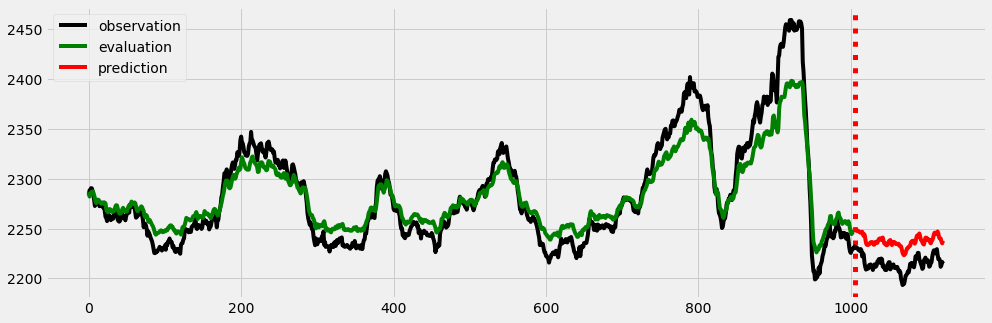

In [123]:
#画完整图
observed=np.hstack((y_train,y_test)) 
evaluated=y_train_predict
predicted=y_test_predict
observed_times=np.arange(len(y_train)+len(y_test))
evaluated_times=np.arange(len(y_train))
predicted_times=np.arange(len(y_train),len(y_train)+len(y_test))
plt.figure(figsize=(15, 5))
plt.axvline(len(y_train), linestyle="dotted", linewidth=5, color='r')
observed_lines = plt.plot(observed_times, observed, label="observation", color="k")
evaluated_lines = plt.plot(evaluated_times, evaluated, label="evaluation", color="g")
predicted_lines = plt.plot(predicted_times, predicted, label="prediction", color="r")

plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],
         loc="upper left")
#为训练，验证，预测数据分别创建图例
plt.show()